<a href="https://colab.research.google.com/github/MayerT1/Pakistan_Research/blob/main/Step_5_Forest_Structure_Function_Module_Python_PFI_Test_ROI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation / Comparison module for mapping forest strucure with GEDI

*   Author T. Mayer 7/24/24; NASA SERVIR, Univeristy of Alabama in Huntsville, and University of Twente ITC
*   Script for cross comparsing various canopy Height Modles and in situ to compare RF model products
*   Similar function as used here are offered in a a GEE JS. See the Github
*   Recommend to use this notebook as the charting is more robust in python




In [ ]:
!pip install geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.2 MB/s eta 0:00:00


In [ ]:
# import ee
# import geemap
# import geemap.chart as chart

In [ ]:
!pip install scikit-plot

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 42.8 MB/s eta 0:00:00


In [ ]:
!pip install xarray

In [ ]:
# Import seaborn
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import rasterio
import xarray as xr
import scipy
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
import ee
import geemap
import geemap.chart as chart
ee.Authenticate()
ee.Initialize(project='servir-sco-assets')
Map = geemap.Map()

In [ ]:
js_snippet = """


"""

In [ ]:
geemap.js_snippet_to_py(
    js_snippet, add_new_cell=True, import_ee=True, import_geemap=True, show_map=True
)

print("canopy_ht_gte_only", canopy_ht_gte_only.getInfo())


In [ ]:
lines = geemap.js_snippet_to_py(js_snippet, add_new_cell=False, import_ee=True, import_geemap=True, show_map=True)
for line in lines:
    print(line.rstrip())

In [ ]:
Regression_Predicted_Image = ee.Image("projects/servir-sco-assets/assets/SCO_HKH/KP_Height_Prelim/Regression_Predicted_Image_PFI_Test_ROI")
Map.addLayer(Regression_Predicted_Image, {}, 'Regression_Predicted_Image')


ROI = Regression_Predicted_Image.geometry()
Map.addLayer(ROI, {}, 'ROI')
Map.centerObject(ROI,10);



# ROI = ee.Geometry.Rectangle([24.483975980464127,-33.345729637978984,23.649015042964127,-33.83078248926919])
# # Map.addLayer(ROI, {}, 'ROI')
# # Map.centerObject(ROI,10);

# SA_prediction = ee.Image('projects/servir-sco-assets/assets/SCO_Global/SA_Rest/SA_Rest_Regression_Predicted_Image')
# # Map.addLayer(SA_prediction, {}, "SA_prediction")

Map

Map(center=[34.344342372627665, 72.75989984828747], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
glad = ee.Image("projects/glad/GLCLU2020/Forest_height_2020")
canopy_ht = ee.ImageCollection("projects/meta-forest-monitoring-okw37/assets/CanopyHeight")
in_situ = ee.FeatureCollection('users/tjm0042/PHD/SA_Rest/Height_Avg_max_xycsv')

# Glad

In [ ]:
#/toggle off these two lines for bareground concerns
glad_add_gte = glad.gte(1).clip(ROI);
glad_add_gte_only = glad.updateMask(glad_add_gte)

###/Glad
stacked_Comp_glad = Regression_Predicted_Image.addBands(glad_add_gte_only)
#print("stacked_Comp_glad", stacked_Comp_glad)
Map.addLayer(stacked_Comp_glad, {}, "stacked_Comp_glad")

##Random sample approach
rand_Pts = ee.FeatureCollection.randomPoints(stacked_Comp_glad.geometry(), 1000, 42, 10)
#print("rand_Pts", rand_Pts)
Map.addLayer(rand_Pts, {}, "rand_Pts")

glad_sample = stacked_Comp_glad.sample(**
 {'region':rand_Pts, 'scale':1, 'numPixels': 500000, 'seed':42,"geometries": True}
                                       )
# print("glad_sample", glad_sample.getInfo())
# print("glad_sample", glad_sample.first())
#Map.addLayer(glad_sample, {} , "glad_sample", False)

#Map

In [ ]:
glad_sample_df = geemap.ee_to_df(glad_sample)
print("glad_sample_df", glad_sample_df)
y_true_glad = glad_sample_df['b1']
print('y_true', y_true_glad.shape)
y_pred_glad = glad_sample_df['classification']
print('y_pred', y_pred_glad.shape)

print("MAE",mean_absolute_error(y_true_glad,y_pred_glad))

print("MSE",mean_squared_error(y_true_glad,y_pred_glad))

r2 = r2_score(y_true_glad,y_pred_glad)
print("R2", r2)

print("RMSE",np.log(np.sqrt(mean_squared_error(y_true_glad,y_pred_glad))))

glad_sample_df      b1  classification
0    10       20.784149
1    11       18.442556
2     9       11.498878
3    12       27.950081
4     6       19.941507
..   ..             ...
526  12       18.104631
527   9       12.926964
528   9       16.281054
529   9       16.225185
530  13       17.039692

[531 rows x 2 columns]
y_true (531,)
y_pred (531,)
MAE 6.937364576451073
MSE 63.660561976785544
R2 -1.0186232445409877
RMSE 2.0767826247999315


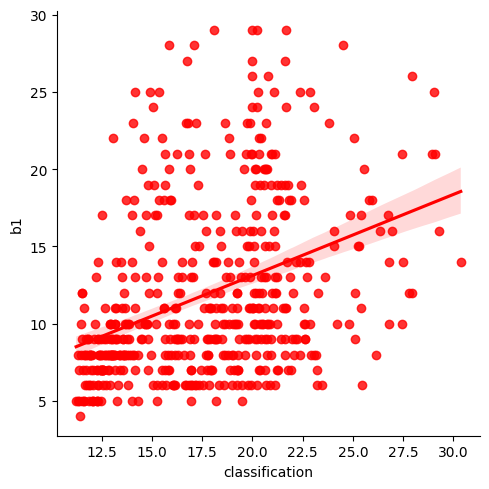

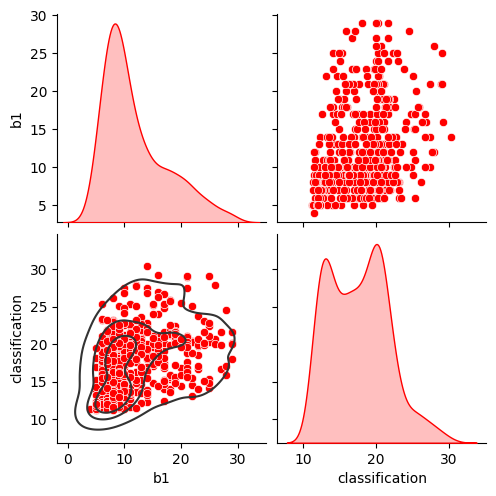

In [ ]:
# sns.relplot(data=glad_sample_df, x='classification', y='b1')
# sns.pairplot(glad_sample_df, kind="hist") #kind="hist" kde

sns.lmplot(data=glad_sample_df,x = 'classification', y = 'b1')

g = sns.pairplot(glad_sample_df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

# WRI

In [ ]:
#/toggle off these two lines for bareground concerns

def func_dwu(image):
    image_2 = image.gte(1)
    image_3 = image.updateMask(image_2)
    return image_3.clip(ROI)

canopy_ht_gte_only = canopy_ht.map(func_dwu).mosaic()
#print("canopy_ht_gte_only", canopy_ht_gte_only)

###/wri
stacked_Comp_wri = Regression_Predicted_Image.addBands(canopy_ht_gte_only)
#print("stacked_Comp_wri", stacked_Comp_wri.getInfo())
#Map.addLayer(stacked_Comp_wri, {}, "stacked_Comp_wri")

##Random sample approach
rand_Pts_wri = ee.FeatureCollection.randomPoints(stacked_Comp_wri.geometry(), 1000, 42, 10)
#print("rand_Pts", rand_Pts)
#Map.addLayer(rand_Pts_wri, {}, "rand_Pts_wri")

wri_sample = stacked_Comp_wri.sample(**
 {'region':rand_Pts_wri, 'scale':1, 'numPixels': 500000, 'seed':42,"geometries": True}
                                       )
# print("wri_sample", wri_sample.getInfo())
# print("wri_sample", wri_sample.first())
# Map.addLayer(wri_sample, {} , "wri_sample", False)

# Map

In [ ]:
wri_sample_df = geemap.ee_to_df(wri_sample)
print("wri_sample_df", wri_sample_df)
y_true_wri = wri_sample_df['cover_code']
print('y_true', y_true_wri.shape)
y_pred_wri = wri_sample_df['classification']
print('y_pred', y_pred_wri.shape)

print("MAE",mean_absolute_error(y_true_wri,y_pred_wri))

print("MSE",mean_squared_error(y_true_wri,y_pred_wri))

r2 = r2_score(y_true_wri,y_pred_wri)
print("R2", r2)

print("RMSE",np.log(np.sqrt(mean_squared_error(y_true_wri,y_pred_wri))))

wri_sample_df      classification  cover_code
0         21.162876           2
1         12.326565           2
2         17.116911           5
3         16.258160           8
4         17.321398           2
..              ...         ...
278       14.131480          15
279       15.242714          15
280       16.384674           5
281       19.868509           4
282       13.272295           2

[283 rows x 2 columns]
y_true (283,)
y_pred (283,)
MAE 12.440800538753873
MSE 186.85669428141432
R2 -5.421021151293369
RMSE 2.615170991162158


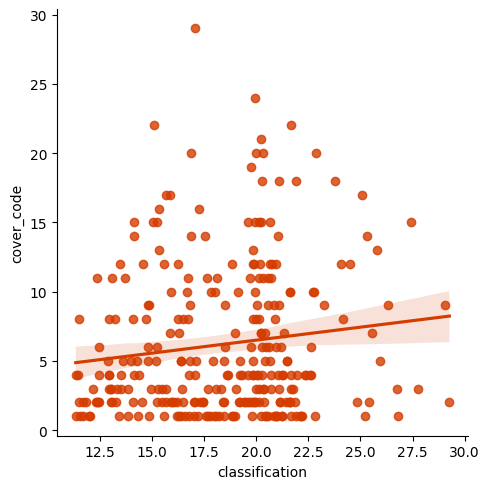

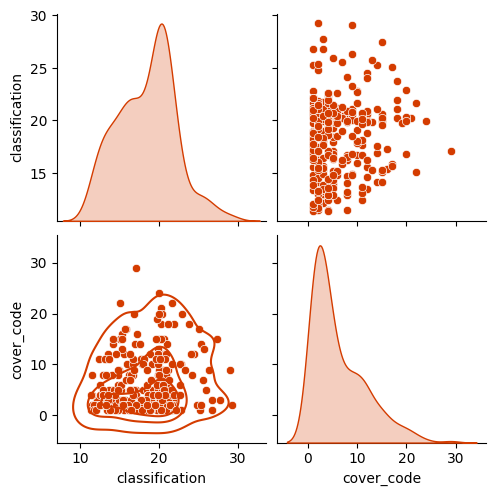

In [ ]:
# sns.relplot(data=glad_sample_df, x='classification', y='b1')
# sns.pairplot(glad_sample_df, kind="hist") #kind="hist" kde


# To add color use this ## note it affects all cells
# custom_palette1 = ["#d43c00"]
# sns.set_palette(custom_palette1)


sns.lmplot(data=wri_sample_df,x = 'classification', y = 'cover_code', )

g = sns.pairplot(wri_sample_df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4,)

# In Situ

In [ ]:
in_situ_out = in_situ #.filter(ee.Filter.lte('Max_Total_height', 9998)) //remove n/a
print("in_situ_out", in_situ_out)
Map.addLayer(in_situ_out, {}, "in_situ_out", False)

stacked_Comp_insitu = Regression_Predicted_Image.sampleRegions(**{'collection': in_situ_out, "properties": ["Max_Total_height"], 'scale': 10});

Map.addLayer(stacked_Comp_insitu, {}, "stacked_Comp_insitu", False)
# print('stacked_Comp_insitu', stacked_Comp_insitu);

# Map

in_situ_out ee.FeatureCollection({
  "functionInvocationValue": {
    "functionName": "Collection.loadTable",
    "arguments": {
      "tableId": {
        "constantValue": "users/tjm0042/PHD/SA_Rest/Height_Avg_max_xycsv"
      }
    }
  }
})
stacked_Comp_insitu ee.FeatureCollection({
  "functionInvocationValue": {
    "functionName": "Image.sampleRegions",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.loadTable",
          "arguments": {
            "tableId": {
              "constantValue": "users/tjm0042/PHD/SA_Rest/Height_Avg_max_xycsv"
            }
          }
        }
      },
      "image": {
        "functionInvocationValue": {
          "functionName": "Image.load",
          "arguments": {
            "id": {
              "constantValue": "projects/servir-sco-assets/assets/SCO_HKH/KP_Height_Prelim/Regression_Predicted_Image_PFI_Test_ROI"
            }
          }
        }
      },
      "properties": {

Map(bottom=104715.0, center=[34.344342372627665, 72.75989984828747], controls=(WidgetControl(options=['positio…

In [ ]:
insitu_sample_df = geemap.ee_to_df(stacked_Comp_insitu)
#print("insitu_sample_df", insitu_sample_df)
y_true_in = insitu_sample_df['Max_Total_height']
print('y_true', y_true_in.shape)
y_pred_in = insitu_sample_df['classification']
print('y_pred', y_pred_in.shape)

print("MAE",mean_absolute_error(y_true_in,y_pred_in))

print("MSE",mean_squared_error(y_true_in,y_pred_in))

r2 = r2_score(y_true_in,y_pred_in)
print("R2", r2)

print("RMSE",np.log(np.sqrt(mean_squared_error(y_true_in,y_pred_in))))

KeyError: 'Max_Total_height'

In [ ]:
# sns.relplot(data=glad_sample_df, x='classification', y='b1')
# sns.pairplot(glad_sample_df, kind="hist") #kind="hist" kde

sns.lmplot(data=insitu_sample_df,x = 'classification', y = 'Max_Total_height')

g = sns.pairplot(insitu_sample_df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

KeyError: "None of [Index(['Max_Total_height', 'classification'], dtype='object')] are in the [columns]"

# Comp All

DF table set up

In [ ]:
b1 = ["Glad"]

length = 531

for i in range(length - len(b1)):
    b1.append(b1[i])

print(b1)
######
cover_code = ["WRI"]

length = 283

for i in range(length - len(cover_code)):
     cover_code.append(cover_code[i])

print(cover_code)
# ########
# Max_Total_height = ["In_situ"]

# length = 26

# for i in range(length - len(Max_Total_height)):
#      Max_Total_height.append(Max_Total_height[i])

# print(Max_Total_height)

group = np.hstack((b1, cover_code))#, Max_Total_height))
print(group)

['Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad', 'Glad',

In [ ]:
true = np.concatenate((y_true_glad, y_true_wri),axis=0)#, y_true_in),axis=0)
pred = np.concatenate((y_pred_glad, y_pred_wri),axis=0)#, y_pred_in),axis=0)

df = pd.DataFrame()
df['true'] = pd.Series(true)
df['pred'] = pd.Series(pred)
df['variance'] = df.var(1)
df['group'] = pd.Series(group)

df

,true,pred,variance,group
0,10,20.784149,58.148937,Glad
1,11,18.442556,27.695823,Glad
2,9,11.498878,3.122194,Glad
3,12,27.950081,127.202540,Glad
4,6,19.941507,97.182813,Glad
...,...,...,...,...
809,15,14.131480,0.377163,WRI
810,15,15.242714,0.029455,WRI
811,5,16.384674,64.805402,WRI
812,4,19.868509,125.904794,WRI


<Axes: xlabel='pred', ylabel='true'>

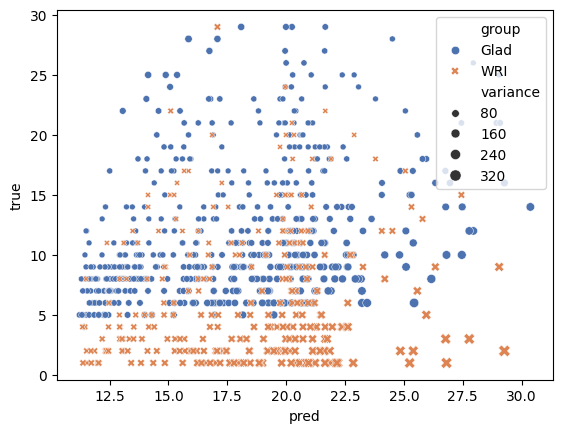

In [ ]:
sns.scatterplot(data=df, x="pred", y="true", hue="group", style="group", size="variance", palette="deep")

<Axes: xlabel='pred', ylabel='true'>

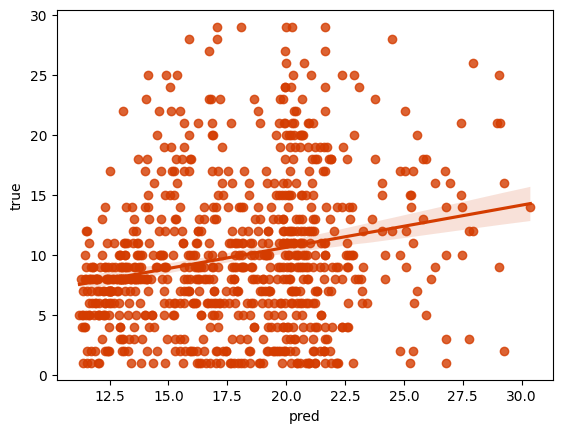

In [ ]:
sns.regplot(data=df, x="pred", y="true")

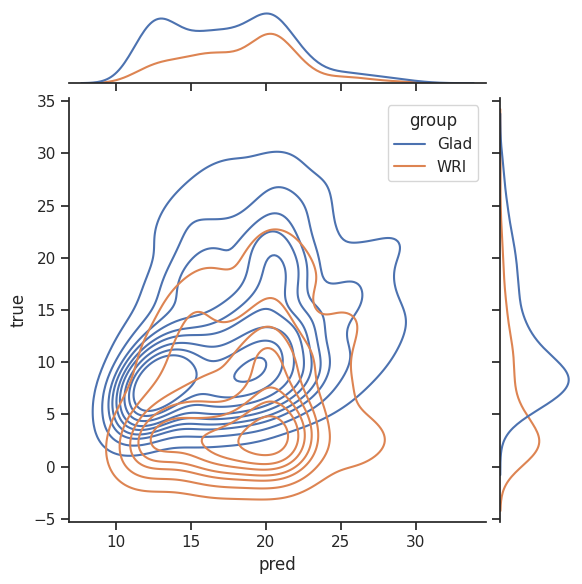

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")
# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=df,
    x="pred", y="true", hue="group",
    kind="kde",
)

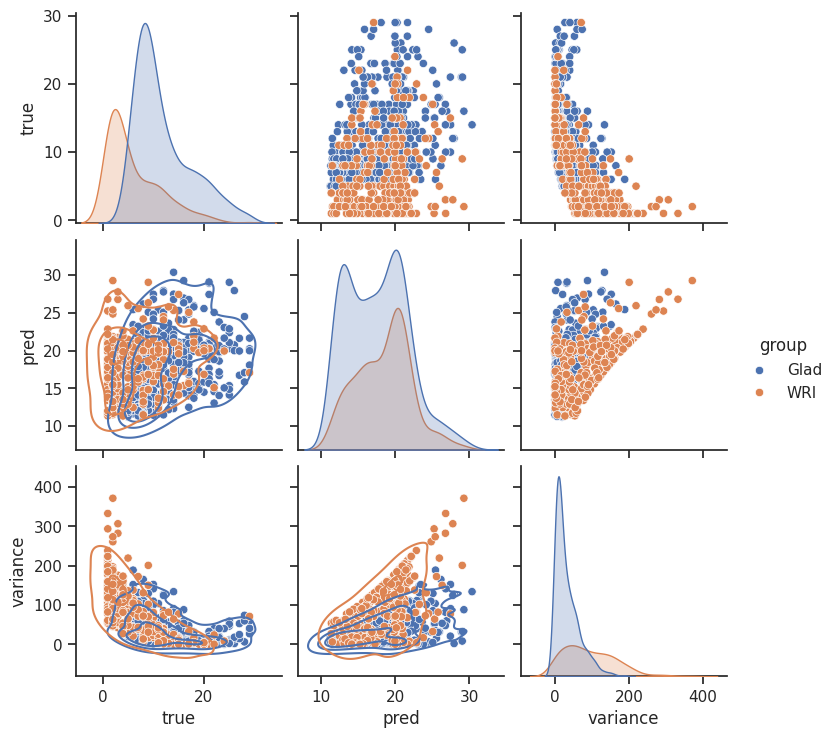

In [ ]:
g = sns.pairplot(df,hue="group", diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

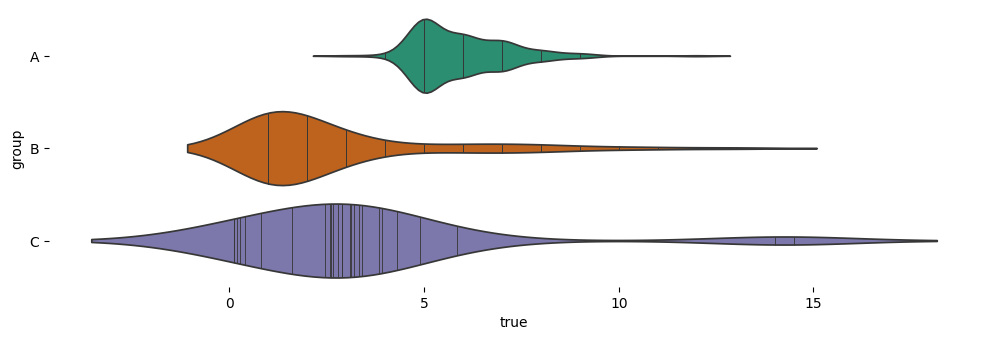

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['group'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='true', y='group', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

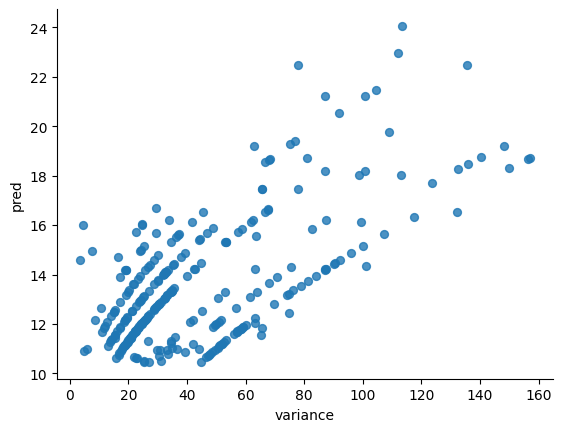

In [ ]:
# from matplotlib import pyplot as plt
# df.plot(kind='scatter', x='variance', y='pred', s=32, alpha=.8)
# plt.gca().spines[['top', 'right',]].set_visible(False)
# #plt.plot([0,100], [0,100])